# Content
- [Setup & Configuration  ](#Setup)
- [Metrics](#Metrics)
- [Data Exploration](#DataExploration)
- [Data Augmentation](#DataAugmentation)
- [Create Model](#CreateModel)
- [Plot the model](#PlotTheModel)
- [Train the model](#TrainTheModel)
- [Plot model history](#PlotModelHistory)
- [Generate .csv for submission](#GeneratePredictions)
- [Overview](#Overview)
- [Notes](#Notes)

## <a id ="Setup">Setup & Configuration</a>

In [ ]:
#########################
# Setup & Configuration  
#######################
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
%matplotlib inline

import os, sys, cv2, random
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import (Input, Dropout, Conv2D, Conv2DTranspose, BatchNormalization,
                          Activation, MaxPooling2D, concatenate, Add)
from keras.preprocessing.image import array_to_img, img_to_array, load_img, save_img

from keras import backend as K
import tensorflow as tf

In [ ]:
#####################
# Global Constants
##################
TRAIN_IMAGE_DIR = '../input/train/images/'
TRAIN_MASK_DIR = '../input/train/masks/'
TEST_IMAGE_DIR = '../input/test/images/'

## <a id="Metrics"> Metrics </a>

In [ ]:
###########
# Metrics
#########
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

## <a id="DataExploration">Data Exploration</a>

In [ ]:
train_imgs = os.listdir(TRAIN_IMAGE_DIR)
X = [np.array(cv2.imread(TRAIN_IMAGE_DIR + img, cv2.IMREAD_GRAYSCALE), dtype= np.uint8) for img in tqdm(train_imgs)]
X = np.array(X)/255
X = np.expand_dims(X, axis=3)

y = [np.array(cv2.imread(TRAIN_MASK_DIR + mask, cv2.IMREAD_GRAYSCALE), dtype= np.uint8) for mask in tqdm(os.listdir(TRAIN_MASK_DIR))]
y = np.array(y)/255
y = np.expand_dims(y, axis=3)

print("XShape: ", X.shape, "YShape: ", y.shape)
# Show some example images
fig, axes = plt.subplots(1,4, figsize=(20,10))
axes[0].imshow(X[1,:,:,0]); axes[0].set_title("image 1", fontsize=18)
axes[1].imshow(y[1,:,:,0]); axes[1].set_title("Mask of image 1", fontsize=18)

axes[2].imshow(X[10,:,:,0]); axes[2].set_title("image 2", fontsize=18)
axes[3].imshow(y[10,:,:,0]); axes[3].set_title("Mask of image 2", fontsize=18)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state = 100, test_size = 0.2)

## <a id="DataAugmentation"> Data augmentation </a>

In [ ]:
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

## <a id="CreateModel"> Create Model </a>

In [ ]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

def build_model(input_tensor_shape, start_neurons, DropoutRatio = 0.5):
    input_layer = Input(input_tensor_shape)
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation('relu')(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation('relu')(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation('relu')(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation('relu')(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation('relu')(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer =  Activation('sigmoid')(output_layer)

    model = Model(inputs=[input_layer], outputs=[output_layer])
    #model.summary()
    model.compile(optimizer=Adam(lr=0.01), metrics=[my_iou_metric], loss='binary_crossentropy') ###
    return model
    
model = build_model(X.shape[1:], 16, 0.3)

## <a id="PlotTheModel"> Plot the model </a>

In [ ]:
from keras.utils import plot_model 
plot_model(model, to_file='keras-baseline-architecture.png')

from IPython.display import Image
#Image(filename='keras-baseline-architecture.png') 

## <a id = "TrainTheModel"> Train the model </a>

In [ ]:
Callbacks =[
    EarlyStopping(monitor='val_my_iou_metric', mode='max', patience=5, verbose=1),
    ModelCheckpoint('model.hdf5', monitor='val_my_iou_metric', mode='max', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
]
model.fit(
    X_train, y_train, epochs = 50,
    validation_data=(X_valid, y_valid),
    callbacks = Callbacks, 
    batch_size=64, verbose=1
);

## <a id="PlotModelHistory"> Plot model history </a>

In [ ]:
def show_history(history):
    plt.plot(history.history['my_iou_metric'])
    plt.plot(history.history['val_my_iou_metric'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_IOU', 'test_IOU'], loc='best')
    plt.show()

show_history(model.history)

## <a id="GeneratePredictions"> Generate .csv for submission </a>

In [ ]:
Lmodel = load_model('model.hdf5',custom_objects={'my_iou_metric': my_iou_metric})

X_test = [np.array(cv2.imread(TEST_IMAGE_DIR + img, cv2.IMREAD_GRAYSCALE), dtype=np.uint8) for img in tqdm(os.listdir(TEST_IMAGE_DIR))]
X_test = np.array(X_test)/255
X_test = np.expand_dims(X_test, axis=3)

pred = Lmodel.predict(X_test, verbose=True)

In [ ]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
    
pred_dict = {img[:-4]:rle_encode(np.round(pred[i,:,:,0])) for i, img in tqdm(enumerate(os.listdir(TEST_IMAGE_DIR)))}

sub = pd.DataFrame.from_dict(pred_dict, orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

## Overview

- Build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.
- This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds.
- In order to reduce the submission file size, our metric uses run-length encoding on the pixel values (list of pairs of values that contain a start position and a run length).
- The pixels are one-indexed and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.
- The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. **It also checks that no two predicted masks for the same image are overlapping**.
- Seismic data is collected using reflection seismology, or seismic reflection. which is similar to X-ray, sonar and echolocation.
- While seismic images show rock boundaries, they don't say much about the rock themselves
- Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. There is typically not much reflectivity inside the salt, unless there are sediments trapped inside it.
- **Images** chosen at various locations chosen at random in the subsurface.
- The images are 101 x 101 pixels and each pixel is classified as either salt or sediment.
- The depth of the imaged location is provided for each image.
- The goal of the competition is to segment regions that contain salt.

## Notes
- ### Evaluation Metric:
- Although this competition metric allows prediction of multiple segmented objects per image, you should submit one (encoded) mask that has every salt region, regardless of whether they are connected.
- If a ground truth is empty and you predict nothing, you get a perfect score for that image. If the ground truth is empty and you predict anything, you get a 0 for that image.
- Metric Example : 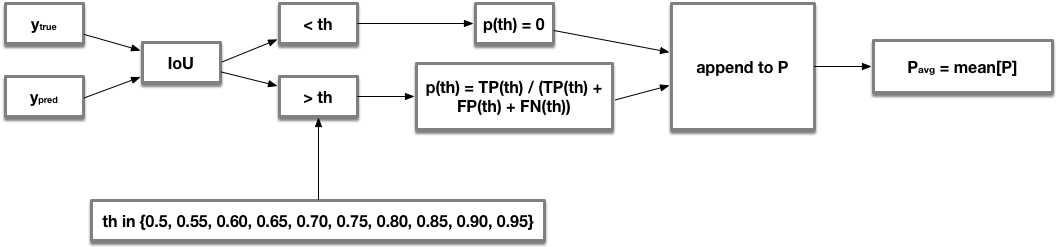
- You can basically forget the notion of connected components for this competition. All True masks values are treated as one big object, with the IoU calculation done using that one big object.
- What is coverage_class ???
- What to monitor and how , EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
- Simple model, doesn't improve even when adding more conv2D and dropout.

- pb: resize or not orginal(101, 101)

In [ ]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(101*101, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(101,101)